## <font style="color:blue">Header</font>

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os
import random
import time
from dataclasses import dataclass
from enum import Enum

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch import optim
from torchvision import transforms
from torchinfo import summary

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
import h5py
import tifffile
import tqdm

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)


def plotData(dataY, rangeY=None, dataYR=None, rangeYR=None,
             dataX=None, rangeX=None, rangeP=None,
             figsize=(16,8), saveTo=None, show=True):

    if type(dataY) is np.ndarray :
        plotData((dataY,), rangeY=rangeY, dataYR=dataYR, rangeYR=rangeYR,
             dataX=dataX, rangeX=rangeX, rangeP=rangeP,
             figsize=figsize, saveTo=saveTo, show=show)
        return
    if type(dataYR) is np.ndarray :
        plotData(dataY, rangeY=rangeY, dataYR=(dataYR,), rangeYR=rangeYR,
             dataX=dataX, rangeX=rangeX, rangeP=rangeP,
             figsize=figsize, saveTo=saveTo, show=show)
        return
    if type(dataY) is not tuple :
        eprint(f"Unknown data type to plot: {type(dataY)}.")
        return
    if type(dataYR) is not tuple and dataYR is not None:
        eprint(f"Unknown data type to plot: {type(dataYR)}.")
        return

    last = min( len(data) for data in dataY )
    if dataYR is not None:
        last = min( last,  min( len(data) for data in dataYR ) )
    if dataX is not None:
        last = min(last, len(dataX))
    if rangeP is None :
        rangeP = (0,last)
    elif type(rangeP) is int :
        rangeP = (0,rangeP) if rangeP > 0 else (-rangeP,last)
    elif type(rangeP) is tuple :
        rangeP = ( 0    if rangeP[0] is None else rangeP[0],
                   last if rangeP[1] is None else rangeP[1],)
    else :
        eprint(f"Bad data type on plotData input rangeP: {type(rangeP)}")
        raise Exception(f"Bug in the code.")
    rangeP = np.s_[ max(0, rangeP[0]) : min(last, rangeP[1]) ]
    if dataX is None :
        dataX = np.arange(rangeP.start, rangeP.stop)

    plt.style.use('default')
    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.xaxis.grid(True, 'both', linestyle='dotted')
    if rangeX is not None :
        ax1.set_xlim(rangeX)
    else :
        ax1.set_xlim(rangeP.start,rangeP.stop-1)

    ax1.yaxis.grid(True, 'both', linestyle='dotted')
    nofPlots = len(dataY)
    if rangeY is not None:
        ax1.set_ylim(rangeY)
    colors = [ matplotlib.colors.hsv_to_rgb((hv/nofPlots, 1, 1)) for hv in range(nofPlots) ]
    for idx , data in enumerate(dataY):
        ax1.plot(dataX, data[rangeP], linestyle='-',  color=colors[idx])

    if dataYR is not None : # right Y axis
        ax2 = ax1.twinx()
        ax2.yaxis.grid(True, 'both', linestyle='dotted')
        nofPlots = len(dataYR)
        if rangeYR is not None:
            ax2.set_ylim(rangeYR)
        colors = [ matplotlib.colors.hsv_to_rgb((hv/nofPlots, 1, 1)) for hv in range(nofPlots) ]
        for idx , data in enumerate(dataYR):
            ax2.plot(dataX, data[rangeP], linestyle='dashed',  color=colors[idx])

    if saveTo:
        fig.savefig(saveTo)
    if not show:
        plt.close(fig)


def plotImage(image) :
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    plt.show()



## <font style="color:blue">Configs</font>

In [ ]:
def set_seed(SEED_VALUE):
    torch.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    np.random.seed(SEED_VALUE)

seed = 7
set_seed(seed)

@dataclass(frozen=True)
class TrainingConfig:
    device: torch.device = 'cuda:0'
    nofEpochs: int = 256
    latentDim: int = 64
    batchSize: int = 64
    labelSmoothFac: float = 0.9 # For Real labels (or set to 1.0 for no smoothing).
    learningRateD: float = 0.00002
    learningRateG: float = 0.00002
    #CHECKPOINT_DIR: str = os.path.join('model_checkpoint', 'dcgan_flickr_faces')

class DatasetConfig:
    gapWidth = 12
    sinoWid = 3*gapWidth
    sinoLen = 128  # 3*sinoWid # 4096
    gapSize = gapWidth * sinoLen
    sinoSize = sinoWid * sinoLen


## <font style="color:blue">Data</font>

In [ ]:

class StripesFromHDF :

    def __init__(self, sampleName, maskName, bgName=None, dfName=None, loadToMem=True):

        sampleHDF = sampleName.split(':')
        if len(sampleHDF) != 2 :
            raise Exception(f"String \"{sampleName}\" does not represent an HDF5 format.")
        with h5py.File(sampleHDF[0],'r') as trgH5F:
            if  sampleHDF[1] not in trgH5F.keys():
                raise Exception(f"No dataset '{sampleHDF[1]}' in input file {sampleHDF[0]}.")
            self.data = trgH5F[sampleHDF[1]]
            if not self.data.size :
                raise Exception(f"Container \"{sampleName}\" is zero size.")
            self.sh = self.data.shape
            if len(self.sh) != 3 :
                raise Exception(f"Dimensions of the container \"{sampleName}\" is not 3 {self.sh}.")
            self.fsh = self.sh[1:3]
            self.volume = None
            if loadToMem :
                self.volume = np.empty(self.sh, dtype=np.float32)
                self.data.read_direct(self.volume)
                trgH5F.close()

            def loadImage(imageName) :
                if not imageName:
                    return None
                imdata = imread(imageName).astype(np.float32)
                if len(imdata.shape) == 3 :
                    imdata = np.mean(imdata[:,:,0:3], 2)
                #imdata = imdata.transpose()
                if imdata.shape != self.fsh :
                    raise Exception(f"Dimensions of the input image \"{imageName}\" {imdata.shape} "
                                    f"do not match the face of the container \"{sampleName}\" {self.fsh}.")
                return imdata


            self.mask = loadImage(maskName)
            if self.mask is None :
                self.mask = np.ones(self.fsh, dtype=np.uint8)
            self.mask = self.mask.astype(bool)
            self.bg = loadImage(bgName)
            self.df = loadImage(dfName)
            if self.bg is not None :
                if self.df is not None:
                    self.bg -= self.df
                self.mask  &=  self.bg > 0.0

            self.allIndices = []
            for yCr in range(0,self.fsh[0]) :
                for xCr in range(0,self.fsh[1]) :
                    idx = np.s_[yCr,xCr]
                    if self.mask[idx] :
                        if self.volume is not None :
                            if self.df is not None :
                                self.volume[:,*idx] -= self.df[idx]
                            if self.bg is not None :
                                self.volume[:,*idx] /= self.bg[idx]
                        if  xCr + DatasetConfig.sinoWid < self.fsh[1] \
                        and np.all( self.mask[yCr,xCr+1:xCr+DatasetConfig.sinoWid] ) :
                            self.allIndices.append(idx)

    def get_dataset(self, transform=None) :
        class Sinos(torch.utils.data.Dataset) :
            def __init__(self, root, transform=None):
                self.container = root
                self.transform = transforms.Compose([transforms.ToTensor(), transform]) \
                    if transform else transforms.ToTensor()
            def __len__(self):
                return len(self.container.allIndices)
            def __getitem__(self, index):
                idx = self.container.allIndices[index]
                xyrng=np.s_[ idx[0], idx[1]:idx[1]+DatasetConfig.sinoWid ]
                if self.container.volume is not None :
                    data = self.container.volume[:, *xyrng]
                else :
                    data = self.container.data[:, *xyrng]
                    if self.container.df is not None :
                        data -= self.container.df[None,*xyrng]
                    if self.container.bg is not None :
                        data /= self.container.bg[None,*xyrng]
                theta = random.randint(0,data.shape[0]-DatasetConfig.sinoLen-1)
                data = data[theta:theta+DatasetConfig.sinoLen,:]
                if self.transform :
                    data = self.transform(data)
                return data
        return Sinos(self, transform)

sinoRoot = StripesFromHDF("/mnt/ssdData/4176862R_Eig_Threshold-4keV/output/SAMPLE_Y0_BG.hdf:/data",
                          "/mnt/ssdData/4176862R_Eig_Threshold-4keV/output/maskc.tif",
                          None, None)



In [ ]:
dataTransform =  transforms.Compose([
    transforms.Resize((DatasetConfig.sinoLen, DatasetConfig.sinoWid)),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

trainSet = sinoRoot.get_dataset(dataTransform)





In [ ]:
testSet = sinoRoot.get_dataset(dataTransform)
randIdx = random.randint(0,len(testSet)-1)
image = testSet[randIdx].squeeze()
#image += 1
#image /=2
mean = image.mean().item() + 1
stdd = image.std().item() / 2
print(mean, stdd, stdd/mean)
plt.imshow(image.transpose(0,1), cmap='gray')
plt.axis("off")
tifffile.imwrite("tmp.tif", image.numpy())


## <font style="color:blue">Save/Load model</font>

In [ ]:
def save_model(model, device, model_path):
    if not device == 'cpu':
        model.to('cpu')
    torch.save(model.state_dict(), model_path)
    if not device == 'cpu':
        model.to(device)
    return

def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    return model

## <font style="color:blue">Models</font>

In [ ]:


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.latent_out = nn.Sequential(
            nn.Linear(TrainingConfig.latentDim, DatasetConfig.gapSize),
            nn.LeakyReLU()
        )

        self.body = nn.Sequential(

            nn.Conv2d(3, 64, (5,3), stride=(2,1)),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 512, 3, stride=(2,1)),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, 3, stride=(2,1)),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, 3, stride=(2,1)),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(12288, 12288),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (512, 6, 4)),

            nn.ConvTranspose2d(512, 512, (4,3), stride=(2,1)),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(512, 512, (4,3), stride=(2,1)),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(512, 512, (4,3), stride=(2,1)),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(512, 512, (4,3), stride=(2,1)),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(512, 512, (3,1)),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 64, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 1, 1),
            nn.Tanh()


        )
        torch.nn.init.xavier_uniform_(self.body[0].weight)


    def forward(self, input):
        image, noise = input
        latent = self.latent_out(noise).view(-1, DatasetConfig.sinoLen, DatasetConfig.gapWidth)
        imLeft = image[:,:,:,0:DatasetConfig.gapWidth]
        imRight = image[:,:,:,2*DatasetConfig.gapWidth:3*DatasetConfig.gapWidth]
        modelIn = torch.cat((imLeft, latent.unsqueeze(1),imRight), dim=1)
        patch = self.body(modelIn) * 2 + 0.5
        #plotImage(modelIn[0,0,...].detach().cpu().squeeze().transpose(0,1))
        #plotImage(modelIn[0,1,...].detach().cpu().squeeze().transpose(0,1))
        #plotImage(modelIn[0,2,...].detach().cpu().squeeze().transpose(0,1))
        #plotImage(patch[0,...].detach().cpu().squeeze().transpose(0,1))
        return patch




#if model is not None:
#    del model
#    gc.collect()
#    torch.cuda.empty_cache()
generator = Generator()
##model = load_model(model, "/home/imbl/usr/src/ReMuse/experiments/e0134_model.pt")
#print(generator)
#inputData = ( torch.zeros((1,1,DatasetConfig.sinoLen,DatasetConfig.sinoWid)), torch.zeros((1,TrainingConfig.latentDim)) )
model_summary = summary(generator, input_data=[[ image.unsqueeze(0).unsqueeze(0),
                                                 torch.randn((1,TrainingConfig.latentDim)) ]] ).__str__()
print(model_summary)




In [ ]:

class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.body = nn.Sequential(

            nn.Conv2d(1, 64, 3, stride=(2,1)),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 512, 3,stride=2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, 3, stride=(2,1)),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, 3, stride=2),
            nn.LeakyReLU(0.2),

        )
        torch.nn.init.xavier_uniform_(self.body[0].weight)

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(21504, 1024),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )


    def forward(self, input):
        convRes = self.body(input)
        res = self.head(convRes)
        return res


discriminator = Discriminator()
#model = load_model(model, "/home/imbl/usr/src/ReMuse/experiments/e0134_model.pt")
#print(discriminator)
model_summary = summary(discriminator, (1,1,DatasetConfig.sinoLen,DatasetConfig.sinoWid) ).__str__()
print(model_summary)

## <font style="color:blue">Metrics</font>

In [ ]:
BCE = nn.BCELoss(reduction='none')

def loss_func(y_true, y_pred, weights):
    loss = BCE(y_pred, y_true).squeeze()
    loss *= weights
    return loss.sum() / weights.sum()


## <font style="color:blue">Optimizers</font>

In [ ]:

optimizer_G = optim.Adam(
    generator.parameters(),
    lr=TrainingConfig.learningRateG,
    betas=(0.5, 0.999)
)
optimizer_D = optim.Adam(
    discriminator.parameters(),
    lr=TrainingConfig.learningRateD,
    betas=(0.5, 0.999)
)

## <font style="color:blue">Train step</font>

In [ ]:

def generate_images(images) :
    noise = torch.randn(images.shape[0], TrainingConfig.latentDim).to(TrainingConfig.device)
    patches = generator((images, noise))
    outImages = images.clone().detach()
    outImages[...,DatasetConfig.gapWidth:2*DatasetConfig.gapWidth] = patches
    return outImages

#torch.autograd.set_detect_anomaly(True)

def train_step(images):


    optimizer_D.zero_grad()

    images = images.to(TrainingConfig.device)
    means = images.mean(dim=(2,3)).squeeze()
    stdds = images.std(dim=(2,3)).squeeze()
    hweights = stdds / (means+1)
    weights = torch.cat( (hweights, hweights) )
    fakeImages = generate_images(images)
    y_pred_real = discriminator(images)
    y_pred_fake = discriminator(fakeImages)
    #print( torch.mean(y_pred_real).item(), torch.mean(y_pred_fake).item(), end=' ' )
    y_pred_both = torch.cat((y_pred_real, y_pred_fake), dim=0)
    labels = torch.cat( (
        torch.full((y_pred_real.shape[0], 1),  TrainingConfig.labelSmoothFac),
        torch.zeros(y_pred_fake.shape[0], 1) ),
        dim=0
    ).to(TrainingConfig.device)
    D_loss = loss_func(labels, y_pred_both, weights)
    D_loss.backward()
    optimizer_D.step()

    optimizer_G.zero_grad()
    fakeImages = generate_images(images)
    y_pred_fake = discriminator(fakeImages)
    #print(torch.mean(y_pred_fake).item())
    labels = torch.ones(y_pred_fake.shape[0], 1).to(TrainingConfig.device)
    G_loss = loss_func(labels, y_pred_fake, hweights)
    G_loss.backward()
    optimizer_G.step()

    return D_loss, G_loss




G_LOSS = []
D_LOSS = []

def train(dataloader, epochs):

    discriminator.to(TrainingConfig.device)
    generator.to(TrainingConfig.device)

    for epoch in range(epochs):

        generator.train()
        discriminator.train()
        start = time.time()
        D_loss_list, G_loss_list = [], []

        for it , images in tqdm.tqdm(enumerate(dataloader), total=int(len(dataloader))):

            images = images.to(TrainingConfig.device)
            D_loss, G_loss = train_step(images)
            D_loss_list.append(D_loss)
            G_loss_list.append(G_loss)

            if not it % 100 :
                print(f"Discriminator loss: {D_loss:.3f}, Generator loss: {G_loss:.3f}")
                image = images[0,...]
                image.to(TrainingConfig.device)
                fake_image = generate_images(image.unsqueeze(0)).squeeze().transpose(0,1).detach().cpu().numpy()
                image = image.squeeze().transpose(0,1).detach().cpu().numpy()
                twoimages = np.full((DatasetConfig.sinoWid, DatasetConfig.sinoLen*2+20), image.mean())
                twoimages[:, 0:DatasetConfig.sinoLen] = image
                twoimages[:, DatasetConfig.sinoLen+20:2*DatasetConfig.sinoLen+20] = fake_image.squeeze().transpose(0,1)
                plt.imshow(twoimages, cmap='gray')
                plt.axis("off")
                plt.show()
                tifffile.imwrite("tmp.tif", twoimages)
                #print(randIdx, sinoRoot.allIndices[randIdx])



        epoch_D_loss = sum(D_loss_list)/len(D_loss_list)
        epoch_G_loss = sum(G_loss_list)/len(G_loss_list)

        D_LOSS.append(epoch_D_loss.detach().cpu())
        G_LOSS.append(epoch_G_loss.detach().cpu())

        print('\n')
        print(f"Time for epoch {epoch + 1} is {time.time()-start} sec")
        print(f"Generator loss: {epoch_G_loss:.3f}, Discriminator loss: {epoch_D_loss:.3f}")


## <font style="color:blue">Execute</font>

  0%|          | 0/22923 [00:00<?, ?it/s]

Discriminator loss: 0.368, Generator loss: 3.347


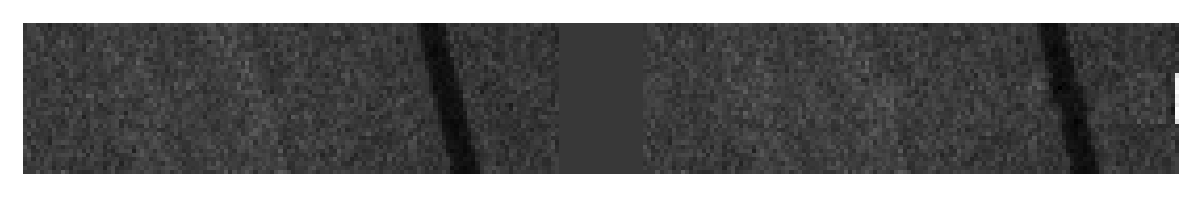

  0%|          | 100/22923 [00:55<3:36:11,  1.76it/s]

Discriminator loss: 0.448, Generator loss: 2.826


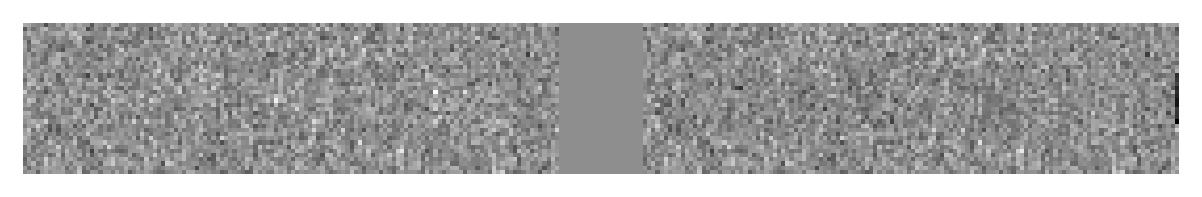

  1%|          | 200/22923 [01:52<3:37:42,  1.74it/s]

Discriminator loss: 0.446, Generator loss: 2.166


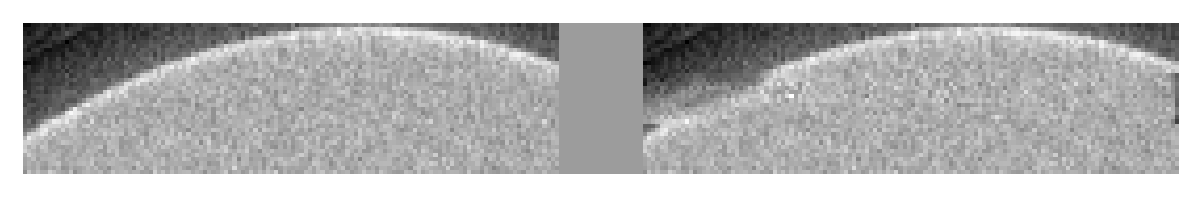

  1%|▏         | 300/22923 [02:50<3:36:43,  1.74it/s]

Discriminator loss: 0.384, Generator loss: 3.823


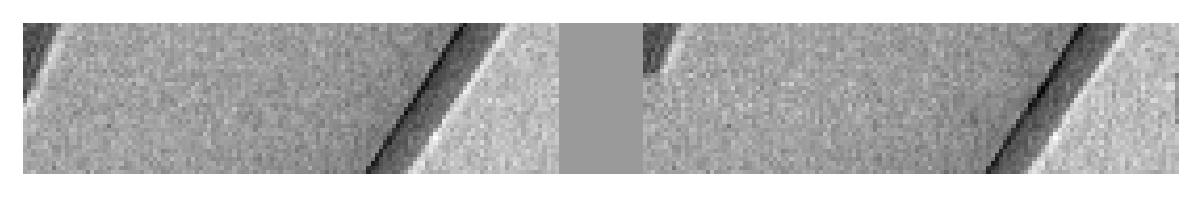

  1%|▏         | 310/22923 [02:56<3:34:14,  1.76it/s]


KeyboardInterrupt: 

In [15]:
trainLoader = torch.utils.data.DataLoader(
    dataset=trainSet,
    batch_size=TrainingConfig.batchSize,
    shuffle=True,
    num_workers=os.cpu_count()
)

train(trainLoader, 5)

In [ ]:
randIdx = random.randint(0,len(testSet)-1)
image = testSet[randIdx]
plt.imshow(image.squeeze().transpose(0,1), cmap='gray')
plt.axis("off")
plt.show()

fake_image = generate_images(image)
plt.imshow(fake_image.detach().squeeze().transpose(0,1), cmap='gray')
plt.axis("off")
plt.show()
